## Imports and setup

In [1]:
# Print stuff inline
%matplotlib inline

# Imports
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud

## Helper functions

In [2]:
# http://stackoverflow.com/questions/33181846/programmatically-convert-pandas-dataframe-to-markdown-table
# This function converts a pandas dataframe to a markdown table.
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return "|" + df_formatted.to_csv(line_terminator="|\n|", sep="|", index=False)[:-2]

## Read in data

In [3]:
# Load he data and drop columns we don't care about.
try:
    data = pd.read_csv("Amazon_Unlocked_Mobile.csv")
    data.drop(['Product Name', 'Brand Name','Price','Review Votes'], axis = 1, inplace = True)
    print "{} Amazon mobile phone reviews with {} features each.".format(*data.shape)
except:
    print "You need to download the dataset from https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones"

413840 Amazon mobile phone reviews with 2 features each.


## Clean Data

In [4]:
def clean_text(string): 
    # Turn warnings off because BeautifulSoup give some we don't care about
    warnings.filterwarnings('ignore')
    
    # Remove xml formatting.
    review_text = BeautifulSoup(string, "lxml").get_text() 
    
    # Turn warnings back on
    warnings.resetwarnings()
    
    # Remove all characters not in the English alphabet
    string = re.sub("[^a-zA-Z]"," ", string)
    
    # Set all characters to lower case.
    string = string.lower()
    
    return string

In [5]:
# Sometimes people leave ratings without reviews. We are going to ignore empty reviews.
data = data[data['Reviews'].isnull()==False]

# Get the ratings column.
ratings = data['Rating']

# Get the reviews column, and clean the reviews.
reviews = map(clean_text, data['Reviews'])

## Explore Data

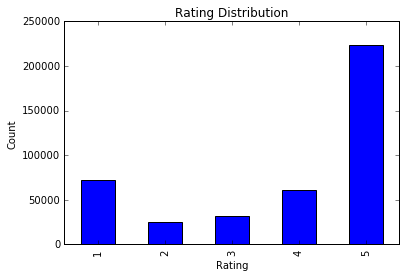

In [6]:
# https://github.com/ipython/ipython/issues/9242
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Create and print a rating distribution graph.
rating_distribution_plt = data.groupby(['Rating']).count().plot(kind='bar', legend=None, title="Rating Distribution")
rating_distribution_plt.set_xlabel("Rating")
rating_distribution_plt.set_ylabel("Count")

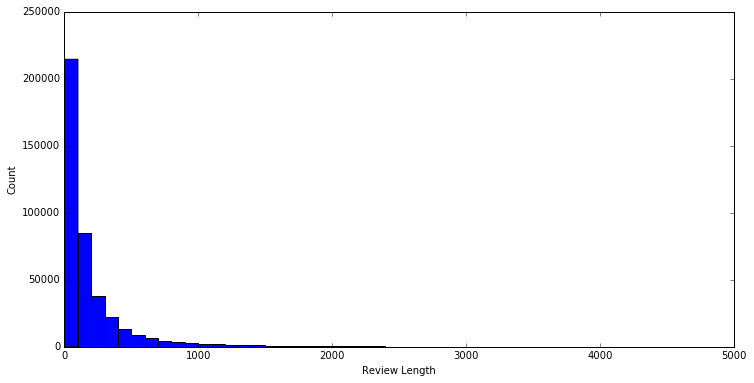

In [7]:
# Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data["Reviews"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.Reviews < 5000]
review_length_distribution_plt.groupby(["Reviews"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', 
                                                                     legend=None, 
                                                                     bins=50, 
                                                                     figsize=(12, 6))
review_length_distribution_plt.set_xlabel("Review Length")
review_length_distribution_plt.set_ylabel("Count")


## Feature Extraction

In [8]:
vectorizer = TfidfVectorizer(
        min_df=2,               # Ignore phrases that are in fewer than 2 reviews
        max_df=0.95,            # Ignore phrases that are in 95% of reviews
        ngram_range = (1,4),    # Take phrases between 1 and 4 words
        stop_words = 'english', # Remove common English words
        # max_features = 300    # The max features amount of features. Set this to 
                                # something small when getting most relevant phrases to 
                                # prevent crases (We have to do some array conversions which 
                                # take a lot of memory)
        )

# Extract features from reviews.
review_features = vectorizer.fit_transform(reviews)

### Get most relevant  phrases

In [9]:
def get_most_relevant_phrases():
    # Convert features into an array
    feature_array = np.array(vectorizer.get_feature_names()) 
    
    # Sort features by weight.
    tfidf_sorting = np.argsort(review_features.toarray()).flatten()[::-1]
    
    # Get the top eight most weighted features.
    top_n = feature_array[tfidf_sorting][:8]
    return top_n

In [10]:
# It's important not to run this unless you set max_features in TfidfVectorizer to something small. 
# The array conversions can take a lot of memory.
# print get_most_relevant_phrases()

## Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                                            review_features,   # The features we created from the reviews
                                            ratings,           # The ratings we are trying to predict
                                            stratify=ratings,  # We have an imbalance of 5-star reviews, so let's stratify
                                            random_state = 12, # Random seed
                                            test_size = 0.3    # We need to save 30% of the data for testing
                                            )
print X_train.shape

(289645, 3553789)


## Get example reviews

In [12]:
# Find a random set of reviews so we can see how each model performs on it.
example_review_set = pd.DataFrame(y_test[191:197].index).join(data, on=0)
print pandas_df_to_markdown_table(example_review_set[['Rating','Reviews']])

|Rating|Reviews|
|---|---|
|5|Excellent product! It's working in Chile with Argentinian and Italian SIM cards. Very good battery life (almost 7 days with regular use).|
|4|Purchased this phone for my son after breaking his iphone. We're pleased with the RCA and he hasn't had any issues with the phone, usage or connectivity and we're on the AT&T network.|
|4|My daughter loves her new phone.|
|2|Stopped working after 6 days. Amazon refunded money with no issues.|
|1|No lo recomiendo. No funciona en Venezuela. No viene con idioma español solo ingles y francés.Not recommend. Does not work in Venezuela.|
|3|I love the keyboard on the phone/and wifi, but the volume is not that great and earpiece did not work with phone.|


### Benchmark model

For the benchmark, we are not going to do any parameter tuning; we are going to use sklearns default parameters. As we will see, logistic regression does fairly well right out of the box.

In [13]:
clf_benchmark = LogisticRegression(random_state=22).fit(X_train, y_train)
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))

             precision    recall  f1-score   support

          1     0.7770    0.9224    0.8434     21701
          2     0.9410    0.3892    0.5507      7417
          3     0.8879    0.4365    0.5852      9529
          4     0.8260    0.4101    0.5481     18412
          5     0.8082    0.9817    0.8865     67074

avg / total     0.8194    0.8093    0.7856    124133



### Other models 

Create an unoptimized MultinomialNB classifier.

In [14]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)
print( classification_report(y_test, clf_NB.predict(X_test), digits=4))

             precision    recall  f1-score   support

          1     0.8839    0.7198    0.7934     21701
          2     0.9990    0.1302    0.2304      7417
          3     0.9976    0.1322    0.2335      9529
          4     0.9982    0.1770    0.3007     18412
          5     0.6637    0.9991    0.7976     67074

avg / total     0.7975    0.7099    0.6460    124133



Create an unoptimized SGDClassifier classifier.

In [15]:
clf_SGD = SGDClassifier(random_state=22)
clf_SGD.fit(X_train, y_train)
print( classification_report(y_test, clf_SGD.predict(X_test), digits=4))

             precision    recall  f1-score   support

          1     0.6886    0.8009    0.7405     21701
          2     0.9163    0.1048    0.1880      7417
          3     0.8575    0.1105    0.1958      9529
          4     0.7882    0.0509    0.0957     18412
          5     0.6929    0.9879    0.8145     67074

avg / total     0.7323    0.6961    0.6100    124133



### Refinement 

The alpha paramter determines what value we give the when we see a feature that we haven’t encountered in the testing data. We can’t use 0 because MultinomialNB multiplies these probabilities together and our whole prediction becomes 0. For example, if we find a 5-star review with a single word that we’ve never seen in a 5-star review before we don’t want our prediction to be 0.

In [16]:
parameters = { 'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] }
clf_NB_refined = GridSearchCV(MultinomialNB(), parameters)
clf_NB_refined.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [17]:
# Print out the parameters GridSearchCV decided on.
clf_NB_refined.best_params_

{'alpha': 0.1}

The SGDClassifier guide on sklearn’s site gives some reasonable ranges to search over for alpha and n_iter. It recommends the range `10.0**-np.arange(1,7)` for alpha and `np.ceil(10**6 / n)` (n is the size of the training set) as a first guess for n_iter. Since our training size has 289,645 rows, it recommends a n_iter of 3, so we are going to try a couple of values around 3. For penalty, we are just going to try every possible value. Finally, we are going to try three loss functions: hinge (linear SVM), log (logistic regression), perceptron (perceptron algorithm).

In [18]:
parameters = [{ 'loss': ['hinge', 'log', 'perceptron'], 
                'alpha': 10.0**-np.arange(1,7),
                'penalty': ['l1', 'l2', 'elasticnet'],
                'n_iter': [2,3,4,5] }]
clf_SGD_refined = GridSearchCV(SGDClassifier(random_state=22), parameters)
clf_SGD_refined.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=22, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2', 'elasticnet'], 'loss': ['hinge', 'log', 'perceptron'], 'n_iter': [2, 3, 4, 5], 'alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
# Print out the parameters GridSearchCV decided on.
clf_SGD_refined.best_params_

{'alpha': 9.9999999999999995e-07, 'loss': 'log', 'n_iter': 5, 'penalty': 'l2'}

## Compare Models

### Accuracy and F1-Scores

In [20]:
print("\nAccuracy: ")
print( "LogisticRegression: " + repr(accuracy_score(y_test, clf_benchmark.predict(X_test))) )
print( "MultinomialNB:      " + repr(accuracy_score(y_test, clf_NB_refined.predict(X_test))) )
print( "SGDClassifier:      " + repr(accuracy_score(y_test, clf_SGD_refined.predict(X_test))) )

print("\nclassification reports: ")
print( "LogisticRegression: " )
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))
print( "MultinomialNB: " ) 
print( classification_report(y_test, clf_NB_refined.predict(X_test), digits=4))
print( "SGDClassifier: " ) 
print( classification_report(y_test, clf_SGD_refined.predict(X_test), digits=4))


Accuracy: 
LogisticRegression: 0.80928520216219701
MultinomialNB:      0.84929873603312578
SGDClassifier:      0.86363013864161831

classification reports: 
LogisticRegression: 
             precision    recall  f1-score   support

          1     0.7770    0.9224    0.8434     21701
          2     0.9410    0.3892    0.5507      7417
          3     0.8879    0.4365    0.5852      9529
          4     0.8260    0.4101    0.5481     18412
          5     0.8082    0.9817    0.8865     67074

avg / total     0.8194    0.8093    0.7856    124133

MultinomialNB: 
             precision    recall  f1-score   support

          1     0.8570    0.9093    0.8824     21701
          2     0.9379    0.6024    0.7336      7417
          3     0.8819    0.5949    0.7105      9529
          4     0.8536    0.5524    0.6707     18412
          5     0.8383    0.9748    0.9014     67074

avg / total     0.8531    0.8493    0.8392    124133

SGDClassifier: 
             precision    recall  f1-scor

### Performance on example reviews

In [21]:
# Create features on the example reviews.
example_reviews_features = vectorizer.transform(example_review_set.Reviews)

# Predict the reviews with each model.
predicted_ratings_0 = np.hstack(map(clf_benchmark.predict, example_reviews_features))
predicted_ratings_1 = np.hstack(map(clf_NB_refined.predict, example_reviews_features))
predicted_ratings_2 = np.hstack(map(clf_SGD_refined.predict, example_reviews_features))

# We don't need to print the whole review out; just enough to compare to the first table.
def shorten_text(x):
    length = 50
    r = x[:length]
    if len(x) > length:
        r = r + "..."
    return r

# Create a table of reviews.
example_review_table = pd.DataFrame( { 
              'Rating': example_review_set.Rating,
              'LR': predicted_ratings_0,
              'MNB': predicted_ratings_1,
              'SGD': predicted_ratings_2,
              'Review': map(shorten_text, example_review_set.Reviews)
              }
            )

# Reorder columns.
example_review_table = example_review_table[['Rating', 'LR','MNB','SGD','Review']]

# Print reviews in a markdown table.
print pandas_df_to_markdown_table(example_review_table)

|Rating|LR|MNB|SGD|Review|
|---|---|---|---|---|
|5|5|5|5|Excellent product! It's working in Chile with Arge...|
|4|5|5|5|Purchased this phone for my son after breaking his...|
|4|5|5|5|My daughter loves her new phone.|
|2|1|2|2|Stopped working after 6 days. Amazon refunded mone...|
|1|5|5|5|No lo recomiendo. No funciona en Venezuela. No vie...|
|3|3|4|3|I love the keyboard on the phone/and wifi, but the...|


### Confusion Matrices

In [22]:
# A function to help create confusion matrices.
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure( figsize=(9,4), facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(ratings)))
    plt.xticks(tick_marks, set(ratings), rotation=45)
    plt.yticks(tick_marks, set(ratings))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
# A function to create and print confusion matrix.
def create_and_print_confusion_matrix(y_test, predicted, title):
    cm = confusion_matrix(y_test, predicted)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, title) 
    plt.show()

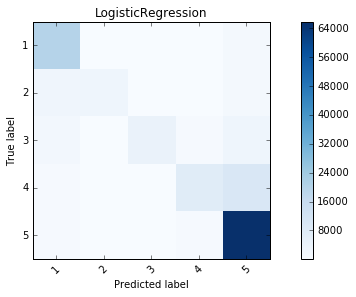

In [24]:
# Create logistic regression confusion matrix.
create_and_print_confusion_matrix(y_test, clf_benchmark.predict(X_test), "LogisticRegression")

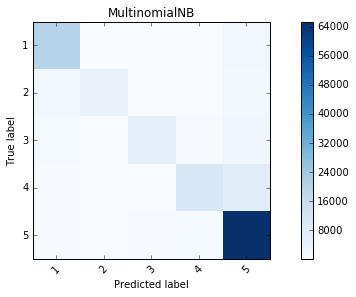

In [25]:
# Create MultinomialNB confusion matrix.
create_and_print_confusion_matrix(y_test, clf_NB_refined.predict(X_test),"MultinomialNB")

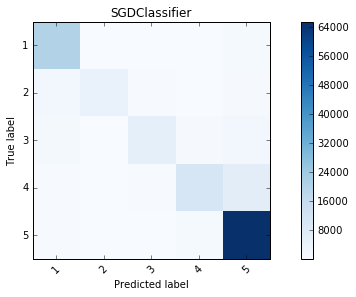

In [26]:
# Create SGDClassifier confusion matrix.
create_and_print_confusion_matrix(y_test, clf_SGD_refined.predict(X_test), "SGDClassifier")

# Wordcloud

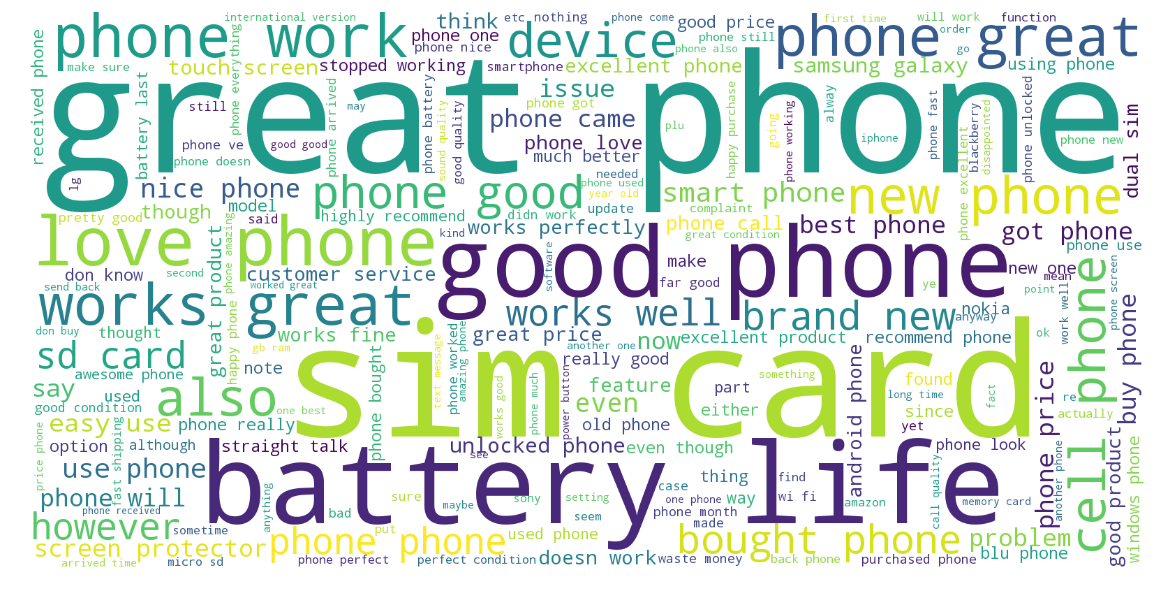

In [27]:
# Create a long string of words.
word_string = ' '.join(reviews)

# Create word cloud using https://github.com/amueller/word_cloud
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=1600,
                      height=800
                     ).generate(word_string)

plt.figure( figsize=(20,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()